In [ ]:
#| default_exp fid

# FID

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *

/home/billy/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/billy/mambaforge/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Classifier

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [ ]:
b = xb,yb = next(iter(dls.train))

Here we load the classifier from `14-augmnet` notebook and move it to the cpu(since it was trained on gpu).

In [ ]:
device = torch.device('cpu')

cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('models/data_aug2.pkl',map_location=device)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

We want to get weights of the 6th layer from this classifier and we can do it in many ways:

> We can create a callback

In [ ]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [ ]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [ ]:
learn.fit(1, train=False, cbs=[hcb])

/home/billy/mambaforge/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/billy/mambaforge/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

Or we can just delete the last two layers from the model.

In [ ]:
del(learn.model[8])
del(learn.model[7])

In [ ]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calc FID

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
smodel = torch.load('models/fashion_ddpm_mp.pkl',map_location=device)

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

In [ ]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 2h 8min 26s, sys: 46min 28s, total: 2h 54min 55s
Wall time: 29min 15s


In [ ]:
device

device(type='cpu')

In [ ]:
s = samples[-1]*2-1

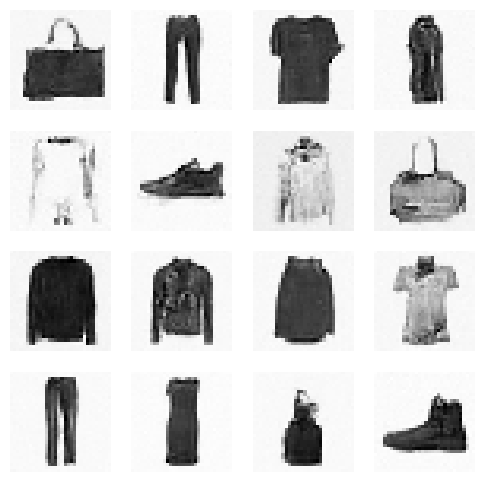

In [ ]:
show_images(s[:16], imsize=1.5)

In [ ]:
clearn = TrainLearner(model, DataLoaders([],[(s,yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [ ]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [ ]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [ ]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

NOTE:
> while using `fid` the number of samples matter low_samples will give you a higher fid score \

In [ ]:
#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [ ]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)

In [ ]:
_calc_fid(*s1, *s2)

39.4581298828125

In [ ]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [ ]:
#|export
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [ ]:
_calc_kid(feats, feats2)

0.23109515011310577

## FID class

In [ ]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [ ]:
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [ ]:
%%time
ie.fid(s)

CPU times: user 2.24 s, sys: 216 ms, total: 2.46 s
Wall time: 413 ms


39.4581298828125

In [ ]:
%%time
ie.kid(s)

CPU times: user 2.28 s, sys: 251 ms, total: 2.53 s
Wall time: 424 ms


0.23109515011310577

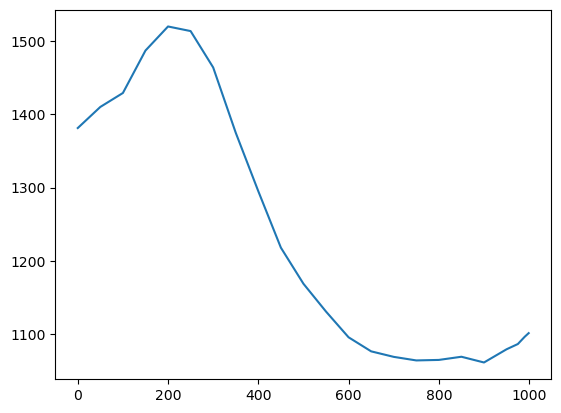

In [ ]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

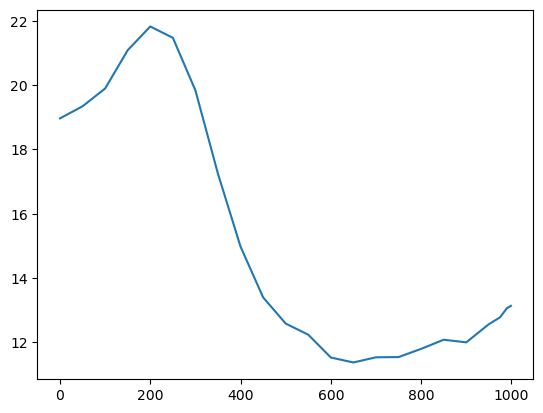

In [ ]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [ ]:
ie.fid(xb)

5.6844482421875

In [ ]:
ie.kid(xb)

-0.021605968475341797

## Inception

In [ ]:
# uncomment to install pytorch-fid
# ! pip install pytorch_fid

In [ ]:
from pytorch_fid.inception import InceptionV3

In [ ]:
a = tensor([1,2,3])
a.repeat((1,3))

tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3]])

In [ ]:
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [ ]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [ ]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

> TODO rerun

It returns OOM error even on 16gb gpu.\
Also where we are just comparing to the InceptionV3 model since all papers use it. and it dosn't provie anything else.

In [ ]:
ie = ImageEval(IncepWrap(), dls, cbs=[DeviceCB()])

: 

In [ ]:
%%time
ie.fid(s)

CPU times: user 1min 11s, sys: 1.61 s, total: 1min 13s
Wall time: 2.31 s


63.81579821823857

In [ ]:
ie.fid(xb)

27.95811916882883

In [ ]:
%%time
ie.kid(s)

CPU times: user 7.44 s, sys: 140 ms, total: 7.58 s
Wall time: 255 ms


0.010766863822937012

In [ ]:
ie.kid(xb)

-8.697943121660501e-05

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()